# Rule-based Classifier

In [32]:
import pandas as pd
import numpy as np

In [33]:
train_data = pd.read_csv('../dataset/train_data.csv')
train_labels = pd.read_csv('../dataset/train_labels.csv')
train_labels = np.ravel(train_labels)

test_data = pd.read_csv('../dataset/test_data.csv')
test_labels = pd.read_csv('../dataset/test_labels.csv')

## Preprocessing Pipeline

In [34]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline 


In [35]:
columns_to_drop = ['_url', 'name',  'profile', 'length',
                            'startlist_quality', 'position', 'cyclist', 'cyclist_team', 
                            'duration', 'cyclist_experience_profile',
                            'cyclist_experience_length', 'cyclist_experience_climb', 
                            'avg_rel_position_length', 'avg_rel_position_climb', 
                            'relative_position_sum', 'relative_position',
                            "climb_cat", "length_cat", "cyclist_number", 
                            "avg_rel_position_profile", "points", 'is_tarmac', 
                            'avg_cyclist_level']

In [36]:
train_data = train_data.drop(columns=columns_to_drop)
test_data = test_data.drop(columns=columns_to_drop)

In [37]:
cat_features = [col for col in ['is_tarmac', 'length_cat', 'climb_cat'] if col not in columns_to_drop]
# Define the preprocessing for numeric and categorical features
numeric_features = [col for col in train_data.columns if col not in cat_features]

num_transformer = StandardScaler()
cat_transformer = OneHotEncoder(handle_unknown='ignore')

# preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numeric_features),
        ('cat', 'passthrough', cat_features)
    ]
)

## RIPPER Model

In [38]:
import wittgenstein as lw
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score, accuracy_score, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix, get_scorer, make_scorer
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from utils import sensitivity_score, specificity_score, precision_with_zero_division, recall_with_zero_division
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbPipeline


In [39]:

pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('sampmler', RandomUnderSampler(random_state=42)),
                       ('classifier', lw.RIPPER())])
param_grid = {
    'classifier__prune_size': [0.1, 0.2, 0.3, 0.4, 0.5],
    'classifier__dl_allowance': [0.1, 0.2, 0.3, 0.4, 0.5],
    'classifier__k': [2, 3, 4, 5, 6, 7, 8, 9, 10],
}

scoring = ['accuracy', 'precision', 'recall', 'f1']

#random grid
random_search = RandomizedSearchCV(pipe, 
                                   param_distributions=param_grid, 
                                   n_iter=50, 
                                   cv=5, verbose=2, 
                                   random_state=42, 
                                   n_jobs=-1,
                                   scoring=scoring, 
                                   refit='f1')
random_search.fit(train_data, train_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END classifier__dl_allowance=0.1, classifier__k=3, classifier__prune_size=0.5; total time=  41.0s
[CV] END classifier__dl_allowance=0.1, classifier__k=3, classifier__prune_size=0.5; total time=  54.5s
[CV] END classifier__dl_allowance=0.3, classifier__k=8, classifier__prune_size=0.1; total time= 1.0min
[CV] END classifier__dl_allowance=0.1, classifier__k=3, classifier__prune_size=0.5; total time= 2.4min
[CV] END classifier__dl_allowance=0.1, classifier__k=3, classifier__prune_size=0.5; total time= 2.5min
[CV] END classifier__dl_allowance=0.5, classifier__k=2, classifier__prune_size=0.5; total time= 2.6min
[CV] END classifier__dl_allowance=0.3, classifier__k=8, classifier__prune_size=0.1; total time= 2.2min
[CV] END classifier__dl_allowance=0.5, classifier__k=2, classifier__prune_size=0.5; total time= 3.5min
[CV] END classifier__dl_allowance=0.1, classifier__k=3, classifier__prune_size=0.5; total time= 3.6min
[CV] END cl

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['climb_total',
                                                                                'cyclist_age',
                                                                                'cyclist_level',
                                                                                'cyclist_experience',
                                                                                'avg_relative_position',
                                                                                'position_entropy',
                                                                                'top_20_entropy']),
                                                                              ('cat',
                                                                               'passthrough',
                                                                               [])])),
                                             ('sampmler',
                                              RandomUnderSampler(random_state=42)),
                                             ('classifier',
                                              <RIPPER(d...iscretize_bins=10, max_rule_conds=None, k=2, random_state=None, prune_size=0.33, alpha=1.0)>)]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'classifier__dl_allowance': [0.1, 0.2,
                                                                     0.3, 0.4,
                                                                     0.5],
                                        'classifier__k': [2, 3, 4, 5, 6, 7, 8,
                                                          9, 10],
                                        'classifier__prune_size': [0.1, 0.2,
                                                                   0.3, 0.4,
                                                                   0.5]},
                   random_state=42, refit='f1',
                   scoring=['accuracy', 'precision', 'recall', 'f1'],
                   verbose=2)

## Model Assessment

### Validation scores:

In [40]:
# extract the results of the randomized search and best model idx
cv_results = random_search.cv_results_
best_model = random_search.best_estimator_
best_index = random_search.best_index_

#extract and print matrics
mean_test_scores = {metric: cv_results[f'mean_test_{metric}'][best_index] for metric in scoring}
std_test_scores = {metric: cv_results[f'std_test_{metric}'][best_index] for metric in scoring}

print("Validation results of the best model:")
for metric in scoring:
    print(f"{metric.capitalize()} - Mean: {mean_test_scores[metric]:.4f}, Std: {std_test_scores[metric]:.4f}")



Validation results of the best model:
Accuracy - Mean: 0.7729, Std: 0.0138
Precision - Mean: 0.2968, Std: 0.0126
Recall - Mean: 0.5170, Std: 0.0658
F1 - Mean: 0.3756, Std: 0.0215


### Test scores:

Accuracy: 0.76
Recall: 0.495
Precision: 0.304
Sensitivity: 0.495
Specificity: 0.806
F1 Score: 0.377
ROC AUC Score: 0.65


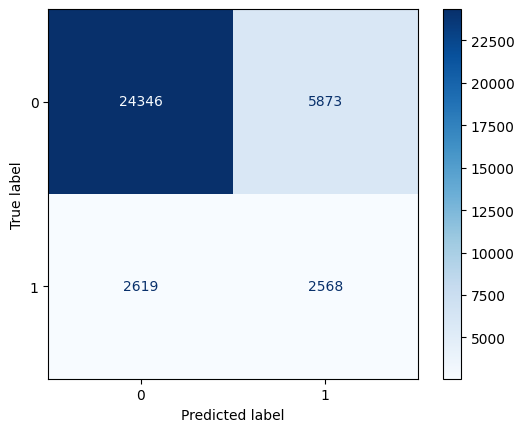

In [41]:
# Predict on the test data
test_predictions = random_search.predict(test_data)

# Calculate and visualize evaluation metrics
accuracy = round(accuracy_score(test_labels, test_predictions), 3)
recall = round(recall_with_zero_division(test_labels, test_predictions), 3)
precision = round(precision_with_zero_division(test_labels, test_predictions), 3)
sensitivity_score = round(sensitivity_score(test_labels, test_predictions), 3)
specificity_score = round(specificity_score(test_labels, test_predictions), 3)
f1 = round(f1_score(test_labels, test_predictions), 3)
roc_auc = round(roc_auc_score(test_labels, test_predictions), 3)
conf_matrix = confusion_matrix(test_labels, test_predictions)

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"Sensitivity: {sensitivity_score}")
print(f"Specificity: {specificity_score}")
print(f"F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.show()


In [42]:
report = classification_report(test_labels, test_predictions)
print(report)

              precision    recall  f1-score   support

           0       0.90      0.81      0.85     30219
           1       0.30      0.50      0.38      5187

    accuracy                           0.76     35406
   macro avg       0.60      0.65      0.61     35406
weighted avg       0.82      0.76      0.78     35406



In [43]:
import joblib
import os

# Create the directory if it doesn't exist
os.makedirs('best_models', exist_ok=True)
# Save the best model
joblib.dump(best_model, 'best_models/nb.pkl')

['best_models/nb.pkl']

OVERSAMPLING (1 iter)

precision    recall  f1-score   support

           0       0.90      0.82      0.86     30219
           1       0.31      0.48      0.38      5187

    accuracy                           0.77     35406
   macro avg       0.61      0.65      0.62     35406
weighted avg       0.81      0.77      0.79     35406


NORMAL 50 iter

 precision    recall  f1-score   support

           0       0.86      0.99      0.92     30219
           1       0.59      0.07      0.13      5187

    accuracy                           0.86     35406
   macro avg       0.72      0.53      0.52     35406
weighted avg       0.82      0.86      0.81     35406


UNDERSAMPLING 50 ITER

 precision    recall  f1-score   support

           0       0.90      0.81      0.85     30219
           1       0.30      0.50      0.38      5187

    accuracy                           0.76     35406
   macro avg       0.60      0.65      0.61     35406
weighted avg       0.82      0.76      0.78     35406